In [17]:
"""
SmallDataTrainer.py
Train a small CNN on a tiny dataset (10 images per emotion)

Loss Function: cross-entropy loss
Algorithm: ADAM (gradient descent w/two moving averages for each weight Average of recent gradients (momentum) + Average of recent squared gradients)
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [18]:
# configuration

img_size = 48  # resize images to 48×48
batch_size = 8  # number of images processed per training step
epochs = 5  # how many times the model sees the whole dataset
learning_rate = 0.001  #step size for updating model weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)


# dataset loading for python in VS code
# current_dir = os.path.dirname(os.path.abspath(__file__))  # path to this file
# project_root = os.path.dirname(os.path.dirname(current_dir))  # go up to project root
# dataset_dir = os.path.join(project_root, "dataset")  # dataset folder path

# dataset loading
project_root = "/bigdata/rhome/bbuh2022/CS158"  # main folder
dataset_dir = os.path.join(project_root, "dataset")  # dataset folder path

using device: cpu


In [19]:
# preprocessing pipeline for all images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # convert to 1-channel grayscale
    transforms.Resize((img_size, img_size)),  # resize all images to 48×48
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  # normalize pixel distribution to [-1,1]
])

In [20]:
# load the small dataset (70 images total)
# automatically creates class names from dataset folder structure.
full_dataset = datasets.ImageFolder(dataset_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)  # number of emotions

print(f"loaded {len(full_dataset)} total images")
print("classes:", class_names)

# split into train 80% (56) and val 20% (14)
train_size = int(0.8 * len(full_dataset))  # training portion
val_size = len(full_dataset) - train_size  # validation portion
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders convert dataset into shuffled batches for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

loaded 49779 total images
classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


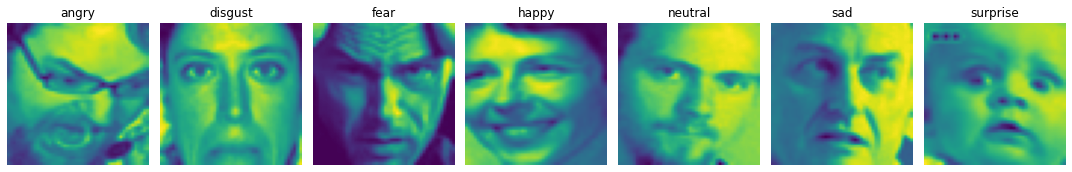

In [21]:
import matplotlib.pyplot as plt

# Get one image from each class
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))

for class_idx, class_name in enumerate(class_names):
    # Find first image of this class
    for img, label in full_dataset:
        if label == class_idx:
            # Convert tensor to numpy for display (C, H, W) -> (H, W, C)
            img_display = img.permute(1, 2, 0).numpy()
            
            # Denormalize if you used normalization in transform
            # img_display = img_display * 0.5 + 0.5  # if normalized with mean=0.5, std=0.5
            
            axes[class_idx].imshow(img_display)
            axes[class_idx].set_title(class_name)
            axes[class_idx].axis('off')
            break  # found one, move to next class

plt.tight_layout()
plt.show()

In [22]:
# model (simple cnn)
class small_cnn(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),  # flatten feature map to vector
            nn.Linear(32 * 12 * 12, 128),  # fully connected layer
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.layers(x)  # forward pass through layers

In [23]:
# create model, loss function, optimizer
model = small_cnn(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
# training functions

def train_one_epoch(epoch):
    model.train()  # set model to training mode
    total_loss = 0  # accumulate loss over epoch
    correct = 0  
    total = 0

    for images, labels in train_loader:  # iterate through mini-batches
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # reset gradients
        outputs = model(images)  # forward pass
        loss = criterion(outputs, labels)  # compute loss
        loss.backward()  # backpropagation
        optimizer.step()  # update weights

        total_loss += loss.item()  # add batch loss
        preds = torch.argmax(outputs, dim=1)  # predicted class
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"epoch {epoch+1}/{epochs}", f"loss={total_loss/len(train_loader):.4f}", f"acc={correct/total:.4f}")

In [25]:
def evaluate():
    model.eval()  # evaluation mode
    correct = 0
    total = 0
    all_preds = []  # store predicted labels
    all_labels = []  # store true labels

    with torch.no_grad():  # do not compute gradients during validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            preds = torch.argmax(outputs, dim=1)  # predicted class
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())  # save predictions
            all_labels.extend(labels.cpu().numpy())  # save true labels

    print(f"validation acc={correct/total:.4f}")
    return all_labels, all_preds

In [ ]:
# run training
for epoch in range(epochs):  # repeat for each epoch
    train_one_epoch(epoch)  # train on training set
    y_true, y_pred = evaluate()  # evaluate on validation set

epoch 1/5 loss=1.3704 acc=0.4784
validation acc=0.5439


In [ ]:
# confusion matrix

cm = confusion_matrix(y_true, y_pred)  # compute confusion matrix

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues"
)
plt.title("validation confusion matrix")
plt.xlabel("predicted")
plt.ylabel("true")
plt.tight_layout()
plt.show()

print("\nclassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))


# save model
torch.save(model.state_dict(), "small_emotion_cnn.pth")  # save learned weights
print("\nmodel saved as small_emotion_cnn.pth")